# NetworkX Interface

NetworkX provides a graph-based representation perfect for analyzing molecular topology and connectivity patterns.

For more information about NetworkX, visit https://networkx.org/

In [1]:
import ase.build
import networkx as nx
from IPython.display import display
from rdkit.Chem import Draw

import molify

## NetworkX → ASE:

The networkx graph contains the positional and chemical infromation and can be easily converted to an ASE Atoms object:

In [2]:
# Create a simple molecule and convert to graph
water = molify.smiles2atoms("O")
water_graph = molify.ase2networkx(water)

print(
    f"Graph: {water_graph.number_of_nodes()} nodes, {water_graph.number_of_edges()} edges"
)

# Convert back to ASE
water_back = molify.networkx2ase(water_graph)
print(f"\nBack to ASE: {water_back}")
print(f"Connectivity preserved: {'connectivity' in water_back.info}")
print(f"Number of bonds: {len(water_back.info['connectivity'])}")

Graph: 3 nodes, 2 edges

Back to ASE: Atoms(symbols='OH2', pbc=False, initial_charges=...)
Connectivity preserved: True
Number of bonds: 2


## NetworkX for Molecular Analysis

### Graph Algorithms: Finding Cycles

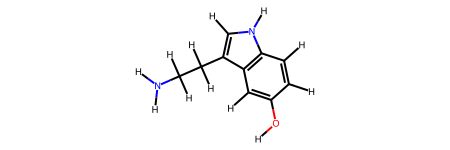


Serotonin: 25 atoms, 26 bonds


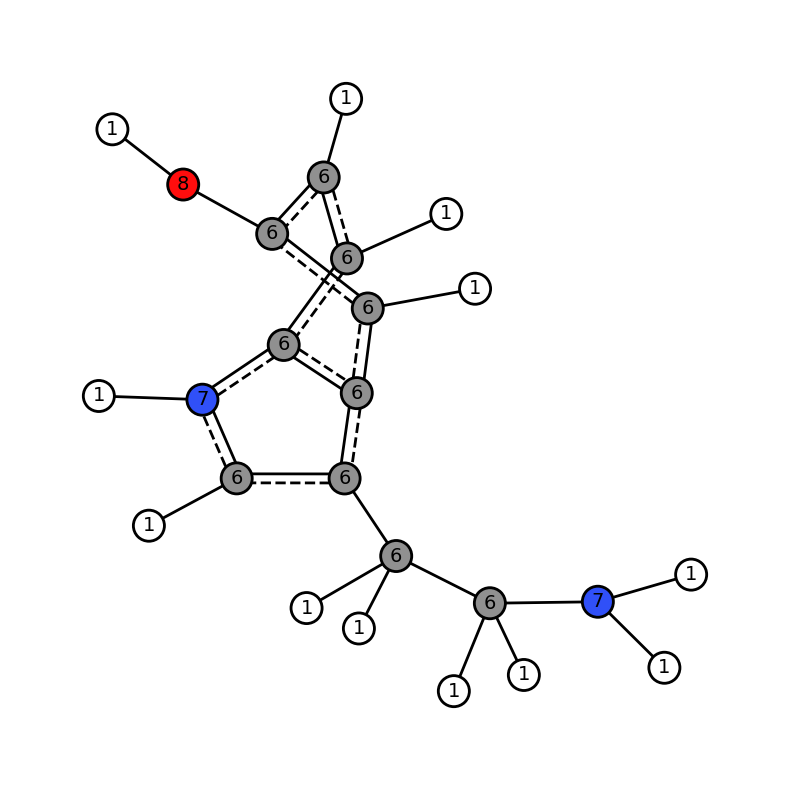

In [3]:
# Create serotonin (has cycles)
serotonin = molify.smiles2atoms("C1=CC2=C(C=C1O)C(=CN2)CCN")
serotonin_mol = molify.ase2rdkit(serotonin)

display(serotonin_mol)

# Analyze with NetworkX
graph = molify.ase2networkx(serotonin)
print(f"\nSerotonin: {graph.number_of_nodes()} atoms, {graph.number_of_edges()} bonds")
molify.draw_molecular_graph(graph)

Found 2 cycles:

Cycle 1 (5 atoms): [3, 2, 9, 8, 7]


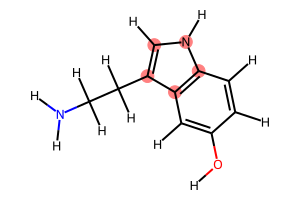

Cycle 2 (6 atoms): [3, 4, 5, 0, 1, 2]


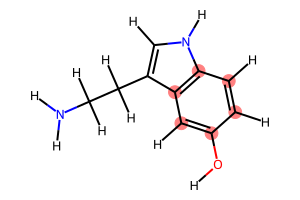

In [4]:
# Find all cycles
cycles = nx.cycle_basis(graph)
print(f"Found {len(cycles)} cycles:\n")

for idx, cycle in enumerate(cycles):
    print(f"Cycle {idx + 1} ({len(cycle)} atoms): {cycle}")
    # Visualize each cycle
    display(Draw.MolToImage(serotonin_mol, highlightAtoms=cycle, size=(300, 200)))

### Analyzing Multi-Molecule Systems

In [5]:
# Create a water/ethanol mixture
water = molify.smiles2conformers("O", numConfs=10)
ethanol = molify.smiles2conformers("CCO", numConfs=10)
box = molify.pack(
    data=[water, ethanol], counts=[5, 5], density=800, packmol="packmol.jl"
)

# Convert to graph
box_graph = molify.ase2networkx(box)
print(
    f"System: {box_graph.number_of_nodes()} atoms, {box_graph.number_of_edges()} bonds"
)

System: 60 atoms, 50 bonds


In [6]:
# Find connected components (individual molecules)
components = list(nx.connected_components(box_graph))
print(f"Found {len(components)} separate molecules")

# Analyze molecule sizes
from collections import Counter

sizes = Counter(len(comp) for comp in components)
print("\nMolecule sizes:")
for size, count in sorted(sizes.items()):
    molecule_type = "water (H2O)" if size == 3 else "ethanol (C2H6O)"
    print(f"  {count} molecules with {size} atoms ({molecule_type})")

Found 10 separate molecules

Molecule sizes:
  5 molecules with 3 atoms (water (H2O))
  5 molecules with 9 atoms (ethanol (C2H6O))


## NetworkX → RDKit: Guessing Bond Orders from 3D Coordinates

### Decision Tree: When Does Bond Order Determination Happen?

```
networkx2rdkit(graph, suggestions)
    ↓
Are all bond_orders present (not None)?
    ├─ YES → Simple conversion ✅
    └─ NO  → Bond order determination required ⚠️
           ↓
           Step 1: Try template matching with suggestions
           ↓
           Step 2: Fallback to rdkit.Chem.rdDetermineBonds
                   (tries charges: 0, ±1, ±2)
```

Let's explore each case:

### Case 1: Graph Has Explicit Bond Orders

When the graph comes from RDKit originally, all bond orders are known:

Bond orders in graph:
  0-1: 1.0
  0-4: 1.0
  0-5: 1.0
  0-6: 1.0
  1-2: 2.0

Conversion successful:


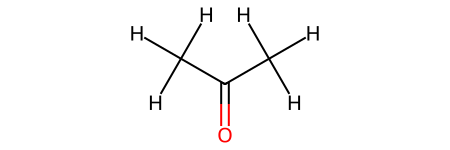

In [7]:
# Create molecule with known bonds
acetone = molify.smiles2atoms("CC(=O)C")  # Has a C=O double bond
acetone_graph = molify.ase2networkx(acetone)

# Check bond orders
print("Bond orders in graph:")
for u, v, data in list(acetone_graph.edges(data=True))[:5]:
    print(f"  {u}-{v}: {data['bond_order']}")

# Convert to RDKit
acetone_mol = molify.networkx2rdkit(acetone_graph)
print("\nConversion successful:")
display(acetone_mol)

### Case 2: Graph Has `bond_order=None`

In [8]:
# Create ammonia from ASE (no connectivity info)
ammonia = ase.build.molecule("NH3")
print(f"Ammonia: {ammonia}")
print(f"Has connectivity: {'connectivity' in ammonia.info}")

# Convert to NetworkX - will have bond_order=None
ammonia_graph = molify.ase2networkx(ammonia)

print("\nGraph edge attributes:")
for u, v, data in ammonia_graph.edges(data=True):
    print(f"  N({u})-H({v}): bond_order = {data['bond_order']}")

Ammonia: Atoms(symbols='NH3', pbc=False)
Has connectivity: False

Graph edge attributes:
  N(0)-H(1): bond_order = None
  N(0)-H(2): bond_order = None
  N(0)-H(3): bond_order = None


Converthing to rdkit with `networkx2rdkit` will run the bond order determination algorithm.

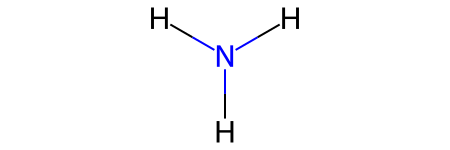

In [9]:
# Convert to RDKit - triggers automatic bond order determination
ammonia_mol = molify.networkx2rdkit(ammonia_graph, suggestions=[])

display(ammonia_mol)

Conversion failed: Failed to determine bonds for sub-structure up to charge -2.0 and ['O', 'P', 'O', 'O', 'O', 'P', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'N', 'C', 'N', 'C', 'C', 'N', 'C', 'N', 'C', 'N', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


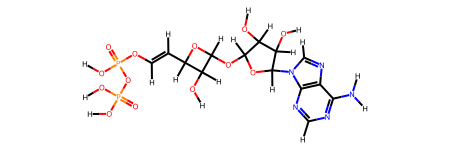

In [10]:
SMILES = "OP(=O)(O)OP(=O)(O)OC=CC1C(O)C(OC2C(C(O)C(N3C=NC4=C3N=CN=C4N)O2)O)O1"

molecule = molify.smiles2atoms(SMILES)
molecule.info.pop("connectivity", None)  # Remove connectivity info
graph = molify.ase2networkx(molecule)

# the automatic bond order determination can fail for complex molecules
try:
    mol = molify.networkx2rdkit(graph, suggestions=[])
except ValueError as e:
    print(f"Conversion failed: {e}")

# but if we know the molecule, we can provide it as a suggestion
# You can also provide a list of suggestions for multiple molecules or multiple guesses
mol = molify.networkx2rdkit(graph, suggestions=[SMILES])
display(mol)
# For very large molecules, this can take a while!

## Key Takeaways

### What We Learned

1. **NetworkX → ASE**: Simple data transfer

2. **NetworkX graphs** are great for:
   - Finding cycles (`nx.cycle_basis`)
   - Counting molecules (`nx.connected_components`)
   - Analyzing topology

3. **NetworkX → RDKit** complexity depends on `bond_order`:
   - If all present → direct conversion
   - If any `None` → Bond order determination

4. **Bond order determination** uses two steps:
   - **Step 1**: Template matching with `suggestions` (SMILES list)
   - **Step 2**: Fallback to `rdkit.Chem.rdDetermineBonds`
     - Tries charges: 0, ±1, ±2
     - Special handling for ions

5. **The "suggestions" parameter**:
   - List of SMILES strings
   - Can be complete molecule or substructures
   - Helps ensure chemical correctness
